## Building an SVD 'Image Prism':

I will attempt to build a low-rank image compressor. Using the Singular Value Decomposition method to "squash" an image using the most important singular values, i.e only show the most important parts of an image.

I will also attempt to implement the SVD method in numpy from scratch and compare it with the actual one


In [3]:
# Load the image

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image = Image.open("me.jpg").convert('L')
img_array = np.array(image)
img_array

array([[174, 172, 169, ..., 188, 188, 188],
       [172, 171, 168, ..., 188, 188, 188],
       [168, 167, 165, ..., 188, 188, 188],
       ...,
       [178, 162, 156, ...,  64, 131, 196],
       [177, 165, 161, ...,  55,  85, 166],
       [168, 162, 163, ...,  56,  56, 131]], shape=(278, 286), dtype=uint8)

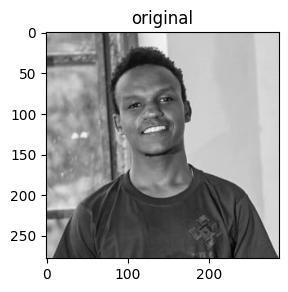

In [4]:
# Visualize image arrays
def visual_image(title, img_array):
    plt.figure(figsize=(3, 5))
    plt.title(title)
    plt.imshow(img_array, cmap='gray')
    plt.show()

visual_image("original", img_array)

In [5]:
img_array.shape, img_array.max()

((278, 286), np.uint8(226))

In [6]:
# normalize the image
img_norm = img_array / 255.0
img_centered = img_norm - np.mean(img_norm) # Center the image so that SVD captures the important patterns

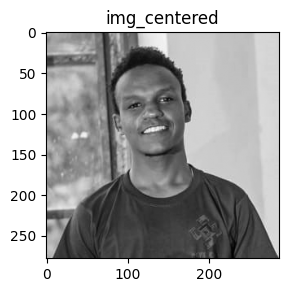

In [7]:
visual_image("img_centered", img_centered)

In [44]:
class SVD:
    def __init__(self, k=4):
        self.k = k # The k highest singular values
    
    def decompose(self, A):
        spd = A.T @ A # Symmetric Postive Definate matrix
        # We calculate it's eigenvalues and eigenvectors
        eigenvalues = np.linalg.eigh(spd).eigenvalues
        sorted_vals = np.argsort(eigenvalues)[::-1]
        eigenvectors = np.linalg.eigh(spd).eigenvectors
        eigenvalues = eigenvalues[sorted_vals]
        eigenvectors = eigenvectors[:, sorted_vals]
        
        reconstruction = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
        if np.allclose(spd, reconstruction) == True:
            v = eigenvectors
            d = np.diag(np.sqrt(np.maximum(eigenvalues, 0)))
            u = np.zeros(shape=(A.shape[0], A.shape[0]))
            for i in range(np.linalg.matrix_rank(A)):
                if d.diagonal()[i] > 1e-10:
                    u[:, i] = 1/d.diagonal()[i] * (A@v[:, i])
                else:
                    u[:, i] = 0
            return u[:, :self.k] @ d[:self.k, :self.k] @ v[:, :self.k].T, np.sqrt(np.maximum(eigenvalues, 0)), np.sqrt(np.maximum(eigenvalues, 0))[self.k] if self.k < len(np.sqrt(np.maximum(eigenvalues, 0))) else 0 
        else:
            print("Not equal")
        

In [45]:
svd = SVD(1)
decomposed_img, singulars, error = svd.decompose(img_centered)
decomposed_img

array([[ 0.02426473,  0.02265225,  0.0191378 , ...,  0.0683196 ,
         0.0620492 ,  0.05714306],
       [ 0.02429132,  0.02267707,  0.01915877, ...,  0.06839448,
         0.06211721,  0.05720569],
       [ 0.0243253 ,  0.0227088 ,  0.01918558, ...,  0.06849016,
         0.06220411,  0.05728571],
       ...,
       [-0.03354714, -0.03131781, -0.02645891, ..., -0.09445508,
        -0.08578597, -0.07900298],
       [-0.03406498, -0.03180124, -0.02686734, ..., -0.09591313,
        -0.08711019, -0.08022251],
       [-0.03465332, -0.03235047, -0.02733137, ..., -0.09756963,
        -0.08861466, -0.08160802]], shape=(278, 286))

In [46]:
error

np.float64(31.773435006727752)

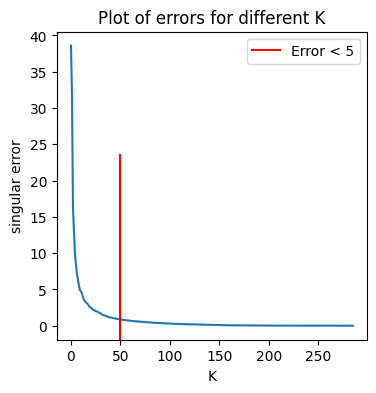

In [47]:
# Plot the singular values to see at which value of k will we have the lowest errors
plt.figure(figsize=(4, 4))
plt.plot(np.arange(0, img_centered.shape[1]), singulars)
plt.axvline(50, 0, 0.6, c='r', label="Error < 5")
plt.legend()
plt.xlabel("K")
plt.ylabel("singular error")
plt.title("Plot of errors for different K")
plt.show()

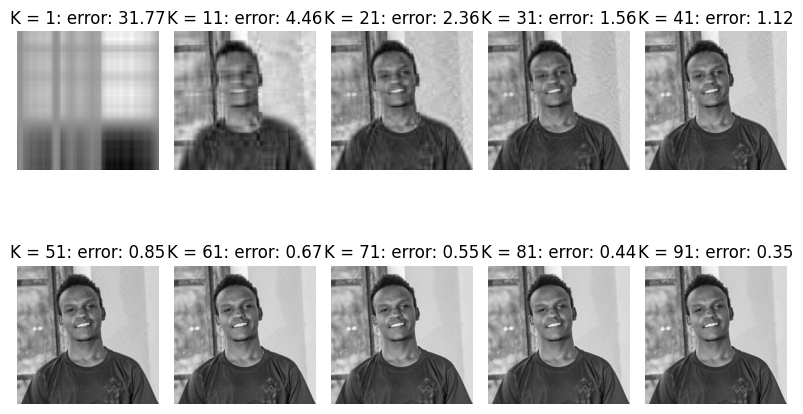

In [48]:
fig, axes = plt.subplots(2, 5, figsize=(8, 8))
axes = axes.flatten()

k_values = list(range(1, 100, 10))

for i, k in enumerate(k_values):
    svd = SVD(k)
    decomposed_img, singulars, error = svd.decompose(img_centered)
    axes[i].imshow(decomposed_img, cmap='gray')
    axes[i].set_title(f"K = {k}: error: {error:.2f}")
    axes[i].axis('off')
    plt.tight_layout()

## Denoising

Add noise to the image so we try and remove it using SVD

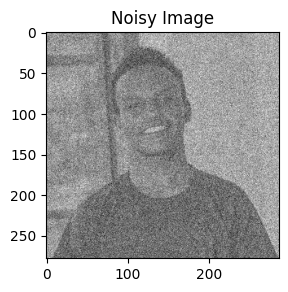

In [81]:
noisy = img_centered + np.random.normal(0, 0.2, img_centered.shape)
visual_image("Noisy Image", noisy)

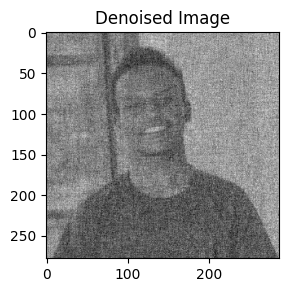

In [87]:
### Denoise the image
svd = SVD(60)
visual_image("Denoised Image", svd.decompose(noisy)[0])